## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

### Import

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [94]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 평가
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    # 결과 출력
    print()
    print("--- Model Performance ---")
    print(f"Model Accuracy: {accuracy}")
    print(f"Model F1 Score: {f1}")
    print(f"Model AUC: {auc}")
    
    # 혼동 행렬 출력
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    return y_pred, y_pred_proba

### Data Load

In [95]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset_50.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset_50.csv')
IVF_train_sub = pd.read_csv('../data/IVF_train_sub_dataset_50.csv')

DI_train = pd.read_csv('../data/DI_train_dataset_50.csv')
DI_test = pd.read_csv('../data/DI_test_dataset_50.csv')
DI_train_sub = pd.read_csv('../data/DI_train_sub_dataset_50.csv')

In [96]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

In [97]:
print(f"IVF_X shape: {IVF_X.shape}")
print(f"IVF_test shape: {IVF_test.drop('ID', axis=1).shape}")

print(f"DI_X shape: {DI_X.shape}")
print(f"DI_test shape: {DI_test.drop('ID', axis=1).shape}")

IVF_X shape: (202130, 61)
IVF_test shape: (87891, 61)
DI_X shape: (6283, 22)
DI_test shape: (2176, 22)


### 인코딩 

In [98]:
IVF_categorical_columns = [
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이"
]

In [99]:
DI_categorical_columns = [
    "특정_시술_유형",
    "정자_기증자_나이"
]

In [100]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [101]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

### IVF 데이터


--- Model Performance ---
Model Accuracy: 0.7269331618265473
Model F1 Score: 0.22603940265021383
Model AUC: 0.7331550624510142


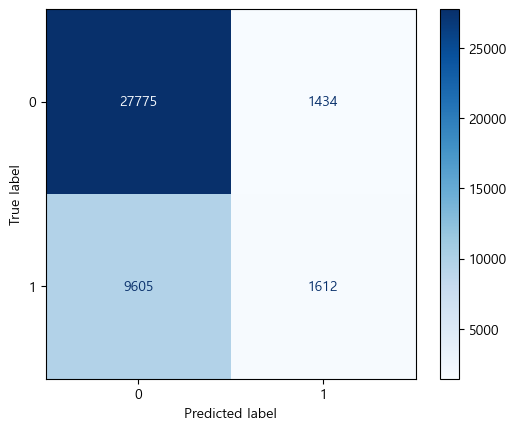

In [102]:
# 모델 초기화
IVF_model = lgb.LGBMClassifier(
    n_estimators=1136,
    num_leaves=1453,
    learning_rate=0.13845866075119073,
    min_child_samples=490,
    reg_alpha=44.99410009292029,
    reg_lambda=134.177514094269,

    random_state=42,
    objective='binary',
    boosting_type='gbdt',
    metric='auc',
    verbose=-1
)

# 모델 학습 및 평가
IVF_y_pred, IVF_y_pred_proba = train_and_evaluate(IVF_model, IVF_X_train, IVF_y_train, IVF_X_test, IVF_y_test)

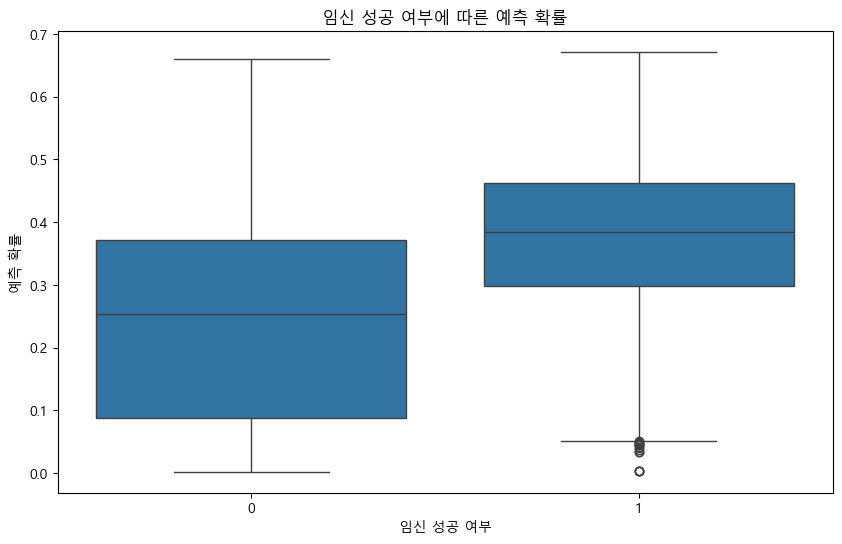

In [103]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

# y_pred_proba를 임신_성공_여부에 따라 박스플롯으로 출력
result_df = pd.DataFrame({'임신_성공_여부': IVF_y_test, '예측_확률': IVF_y_pred_proba})

# 박스플롯 출력
plt.figure(figsize=(10, 6))
sns.boxplot(x='임신_성공_여부', y='예측_확률', data=result_df)
plt.title('임신 성공 여부에 따른 예측 확률')
plt.xlabel('임신 성공 여부')
plt.ylabel('예측 확률')
plt.show()

### DI 데이터


--- Model Performance ---
Model Accuracy: 0.8703261734287987
Model F1 Score: 0.0
Model AUC: 0.6825181413398236


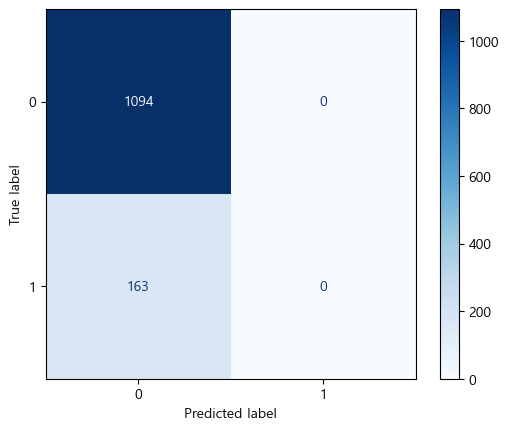

In [104]:
# 모델 초기화
DI_model = lgb.LGBMClassifier(
    n_estimators=3199,
    learning_rate=0.3779934369562745,
    num_leaves=1693,
    min_child_samples=246,
    reg_alpha=5.632304254879699,
    reg_lambda=8.873297193631082,

    random_state=42,
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습 및 평가
DI_y_pred, DI_y_pred_proba = train_and_evaluate(DI_model, DI_X_train, DI_y_train, DI_X_test, DI_y_test)

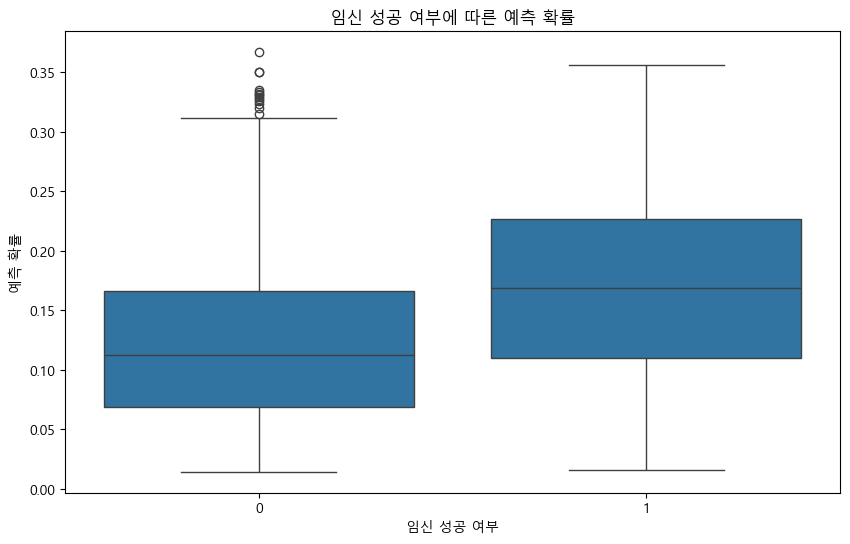

In [105]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

# y_pred_proba를 임신_성공_여부에 따라 박스플롯으로 출력
result_df = pd.DataFrame({'임신_성공_여부': DI_y_test, '예측_확률': DI_y_pred_proba})

# 박스플롯 출력
plt.figure(figsize=(10, 6))
sns.boxplot(x='임신_성공_여부', y='예측_확률', data=result_df)
plt.title('임신 성공 여부에 따른 예측 확률')
plt.xlabel('임신 성공 여부')
plt.ylabel('예측 확률')
plt.show()


--- Combined Model Performance ---
Model Accuracy: 0.731257347119929
Model F1 Score: 0.22348537363094412
Model AUC: 0.7361176139735014


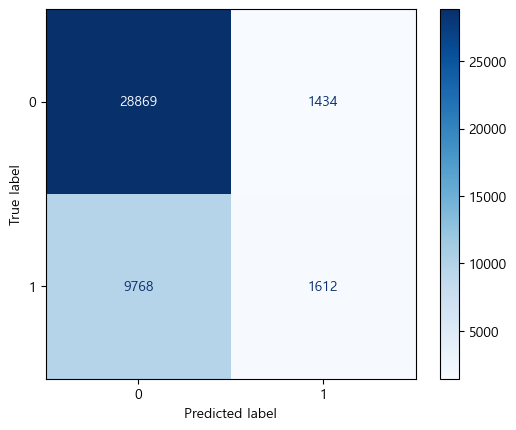

In [106]:
# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred, index=IVF_y_test.index), pd.Series(DI_y_pred, index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba, index=IVF_y_test.index), pd.Series(DI_y_pred_proba, index=DI_y_test.index)])

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Combined Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

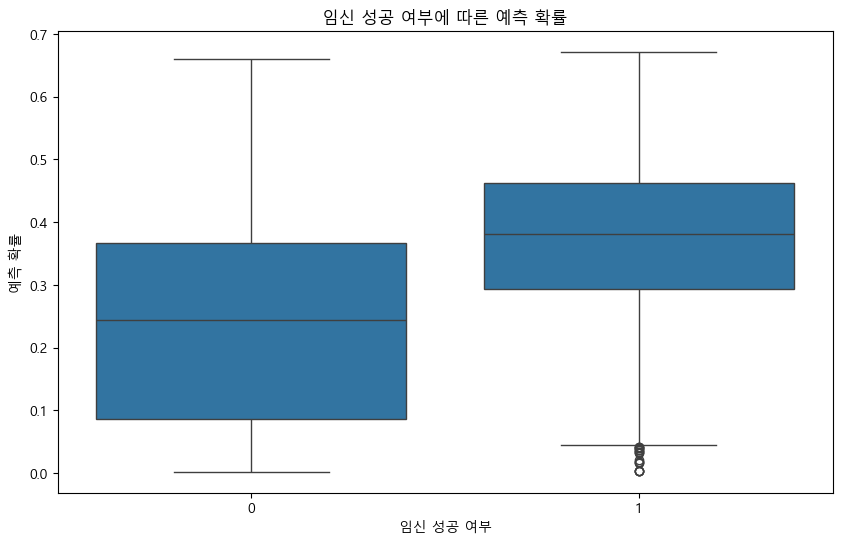

In [107]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

# y_pred_proba를 임신_성공_여부에 따라 박스플롯으로 출력
result_df = pd.DataFrame({'임신_성공_여부': y_test, '예측_확률': y_pred_proba})

# 박스플롯 출력
plt.figure(figsize=(10, 6))
sns.boxplot(x='임신_성공_여부', y='예측_확률', data=result_df)
plt.title('임신 성공 여부에 따른 예측 확률')
plt.xlabel('임신 성공 여부')
plt.ylabel('예측 확률')
plt.show()

데이콘 PUBLIC 0.7342340749

## 제출

In [108]:
import numpy as np
import pandas as pd

# IVF 데이터 전처리
def preprocess_IVF_data(train):
    train_sub = train[train['시술_당시_나이'] == '알 수 없음']
    train = train[train['시술_당시_나이'] != '알 수 없음']

    # 결측값이 존재하는 행을 제외한 후 '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
    train_non_na = train.dropna(subset=['특정_시술_유형'])
    train_sub = pd.concat([train_sub, train_non_na[train_non_na['특정_시술_유형'].isin(['FER', 'GIFT'])]])
    train = train[~train['특정_시술_유형'].isin(['FER', 'GIFT']) | train['특정_시술_유형'].isna()]

    for col in ['불임_원인_-_자궁경부_문제', '불임_원인_-_정자_면역학적_요인']:
        train_sub = pd.concat([train_sub, train[train[col] == 1]])
        train = train[train[col] != 1]

    values_to_drop = ['기증용', '기증용, 난자 저장용', '기증용, 배아 저장용', '난자 저장용', '난자 저장용, 배아 저장용']
    train_sub = pd.concat([train_sub, train[train['배아_생성_주요_이유'].isin(values_to_drop)]])
    train = train[~train['배아_생성_주요_이유'].isin(values_to_drop)]

    for col, threshold in [('저장된_배아_수', 25), ('해동_난자_수', 24), ('저장된_신선_난자_수', 20), 
                           ('총_생성_배아_수', 38), ('미세주입된_난자_수', 44), ('해동된_배아_수', 30), 
                           ('수집된_신선_난자_수', 51), ('미세주입에서_생성된_배아_수', 36), 
                           ('미세주입_후_저장된_배아_수', 24)]:
        train_sub = pd.concat([train_sub, train[train[col] >= threshold]])
        train = train[train[col] < threshold]

    for col, values in [('총_출산_횟수', ['6회 이상']), 
                        ('DI_임신_횟수', ['4회', '5회']), 
                        ('DI_출산_횟수', ['5회'])]:
        train_sub = pd.concat([train_sub, train[train[col].isin(values)]])
        train = train[~train[col].isin(values)]

    train_sub = pd.concat([train_sub, train[train['정자_출처'] == '배우자 및 기증 제공']])
    train = train[train['정자_출처'] != '배우자 및 기증 제공']

    train_sub = pd.concat([train_sub, train[train['난자_해동_경과일'] == 1]])
    train = train[train['난자_해동_경과일'] != 1]

    train_sub = pd.concat([train_sub, train[train['난자_혼합_경과일'] >= 6]])
    train = train[train['난자_혼합_경과일'] < 6]

    train_sub = pd.concat([train_sub, train[train['배아_해동_경과일'] == 7]])
    train = train[train['배아_해동_경과일'] != 7]

    train_sub = pd.concat([train_sub, train[(train['착상_전_유전_진단_사용_여부'] == 1) & (train['착상_전_유전_검사_사용_여부'] == 1)]])
    train = train[~((train['착상_전_유전_진단_사용_여부'] == 1) & (train['착상_전_유전_검사_사용_여부'] == 1))]

    train_sub = pd.concat([train_sub, train[(train['남성_주_불임_원인'] == 1) & (train['남성_부_불임_원인'] == 1)]])
    train = train[~((train['남성_주_불임_원인'] == 1) & (train['남성_부_불임_원인'] == 1))]

    train_sub = pd.concat([train_sub, train[(train['여성_주_불임_원인'] == 1) & (train['여성_부_불임_원인'] == 1)]])
    train = train[~((train['여성_주_불임_원인'] == 1) & (train['여성_부_불임_원인'] == 1))]

    train_sub = pd.concat([train_sub, train[(train['부부_주_불임_원인'] == 1) & (train['부부_부_불임_원인'] == 1)]])
    train = train[~((train['부부_주_불임_원인'] == 1) & (train['부부_부_불임_원인'] == 1))]

    train_sub = pd.concat([train_sub, train[(train['신선_배아_사용_여부'] == 0) & (train['동결_배아_사용_여부'] == 0) & (train['기증_배아_사용_여부'] == 0)]])
    train = train[~((train['신선_배아_사용_여부'] == 0) & (train['동결_배아_사용_여부'] == 0) & (train['기증_배아_사용_여부'] == 0))]

    train_sub = pd.concat([train_sub, train[(train['난자_출처'] == '기증 제공') & (train['정자_출처'] == '미할당')]])
    train = train[~((train['난자_출처'] == '기증 제공') & (train['정자_출처'] == '미할당'))]

    return train, train_sub

# DI 데이터 전처리
def preprocess_DI_data(train):
    train_sub_1 = train[train['임신_시도_또는_마지막_임신_경과_연수'] >= 20]
    train = train[(train['임신_시도_또는_마지막_임신_경과_연수'] < 20) | (train['임신_시도_또는_마지막_임신_경과_연수'].isna())]

    train_sub_2 = train[(train['부부_주_불임_원인'] == 1) & (train['부부_부_불임_원인'] == 1)]
    train = train[~((train['부부_주_불임_원인'] == 1) & (train['부부_부_불임_원인'] == 1))]

    train_sub_3 = train[train['특정_시술_유형'] == 'GIFT']
    train = train[train['특정_시술_유형'] != 'GIFT']

    train_sub_4 = train[train['IVF_임신_횟수'] == '3회']
    train = train[train['IVF_임신_횟수'] != '3회']

    train_sub = pd.concat([train_sub_1, train_sub_2, train_sub_3, train_sub_4])

    return train, train_sub

# 모델 학습 및 예측
IVF_model.fit(IVF_X, IVF_y)
IVF_pred_proba = IVF_model.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]

DI_model.fit(DI_X, DI_y)
DI_pred_proba = DI_model.predict_proba(DI_test.drop('ID', axis=1))[:, 1]

In [109]:
# 특정 조건에 해당하는 경우 타겟 변수의 값을 0부터 0.001 사이의 랜덤 값으로 설정
ivf_mask = IVF_test['ID'].isin(IVF_train_sub['ID'])
di_mask = DI_test['ID'].isin(DI_train_sub['ID'])

if ivf_mask.any():
    IVF_pred_proba[ivf_mask] = np.random.uniform(0, 0.01, ivf_mask.sum())

if di_mask.any():
    DI_pred_proba[di_mask] = np.random.uniform(0, 0.01, di_mask.sum())

# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')  


# 제출 파일 저장
submission.to_csv('../submission/code50_lgbm.csv', index=False, encoding='utf-8')

---

.